# **Text Classification with the News Headlines Dataset**

This notebook demonstrates the implementation of a text classification model using LSTM networks for sarcasm detection, a task that is more challenging compared to traditional sentiment analysis. Its purpose is to detect whether news headlines are sarcastic or not using the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home). Additionally, it includes visualization of word embeddings generated after training.

For a more robust implementation, please visit my next [notebook](https://github.com/JersonGB22/TextClassification-TensorFlow/blob/main/models_transformers/SentimentAnalysis_RoBERTa_Sarcasm.ipynb), where a Transformer network is implemented for sarcasm detection, achieving better results.

### **Imports**

In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.core.display import HTML
from google.colab import drive
import imageio.v2 as imageio
import os

### **Parameters**

In [ ]:
epochs = 8
batch_size = 256
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
vocab_size = 20000 #Including padding and unknown tokens
embedding_dim = 64

### **Load and Preprocess the Dataset**

In [ ]:
data_url = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
data_path = "/content/sarcasm.json"

# Download dataset
!wget -q $data_url  -O $data_path

In [ ]:
df = pd.read_json(data_path)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [ ]:
# There are no null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [ ]:
# The dataset is roughly balanced
(df.is_sarcastic.value_counts()/df.shape[0]) * 100

is_sarcastic
0    56.104684
1    43.895316
Name: count, dtype: float64

In [ ]:
# Splitting the dataframe into training and testing sets

df_train, df_test = train_test_split(df, test_size=0.15, random_state=123, stratify=df["is_sarcastic"])

train_dataset = tf.data.Dataset.from_tensor_slices((df_train["headline"].values, df_train["is_sarcastic"].values))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test["headline"].values, df_test["is_sarcastic"].values))

train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
# Thanks to the 'stratify' argument, the distribution is preserved

print(len(df_train), len(df_test), "\n")
print((df_train.is_sarcastic.value_counts()/df_train.shape[0]) * 100, "\n")
print((df_test.is_sarcastic.value_counts()/df_test.shape[0]) * 100)

22702 4007 

is_sarcastic
0    56.105189
1    43.894811
Name: count, dtype: float64 

is_sarcastic
0    56.101822
1    43.898178
Name: count, dtype: float64


In [ ]:
for texts, labels in train_dataset.take(1):
  print(texts[:3].numpy(), "\n")
  print(labels[:3].numpy())

[b'students punished for sexual assault should have transcripts marked, title ix group says'
 b'cake just sitting there'
 b'4 trump accusers call on congress to investigate sexual misconduct claims'] 

[0 1 0]


**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [ ]:
# Create a custom standardization function

@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  # Convert all text to lowercase
  text = tf.strings.lower(text)
  # Remove dashes
  text = tf.strings.regex_replace(text, r"-+", " ")
  # Remove punctuation
  text = tf.strings.regex_replace(text, r'[!"#$%&()\*\+,\./:;<=>?@\[\\\]^_`{|}~\']', "")
  return text

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize=preprocessing
                                            )
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [ ]:
print(encoder.vocabulary_size())
vocab[:10]

20000


array(['', '[UNK]', 'to', 'of', 'the', 'in', 'for', 'a', 'on', 'and'],
      dtype='<U27')

In [ ]:
encoded_texts = encoder(texts).numpy()
print(encoded_texts.shape)
encoded_texts

(256, 21)


array([[  235, 10588,     6, ...,     0,     0,     0],
       [ 1896,    34,  1458, ...,     0,     0,     0],
       [  202,    13,  4188, ...,     0,     0,     0],
       ...,
       [  236,   105,  7213, ...,     0,     0,     0],
       [15913, 10998,     9, ...,     0,     0,     0],
       [ 8849,   436,  2004, ...,     0,     0,     0]])

In [ ]:
# Visualizing text processing
print(texts[14].numpy().decode("utf-8"), "\n")
print(" ".join(vocab[encoded_texts[14]]))

trademarks show amazon has sights on meal-kits, 'single cow burgers' and other fast food options 

trademarks show amazon has sights on meal kits single cow burgers and other fast food options     


### **Build the Model**

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(),
                              output_dim=embedding_dim,
                              mask_zero=True, #To handle variable sequence lengths
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

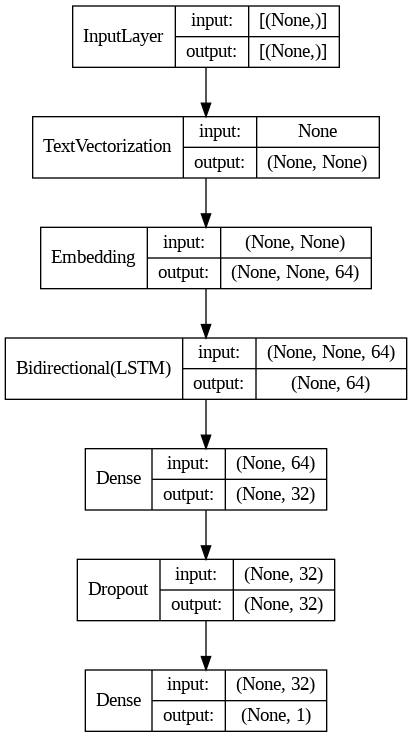

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="binary_crossentropy",
              metrics="accuracy")

In [ ]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/8
89/89 [==============================] - 28s 171ms/step - loss: 0.6896 - accuracy: 0.5617 - val_loss: 0.6851 - val_accuracy: 0.5613
Epoch 2/8
89/89 [==============================] - 7s 82ms/step - loss: 0.6751 - accuracy: 0.5785 - val_loss: 0.6581 - val_accuracy: 0.6042
Epoch 3/8
89/89 [==============================] - 3s 39ms/step - loss: 0.6049 - accuracy: 0.7276 - val_loss: 0.5301 - val_accuracy: 0.8103
Epoch 4/8
89/89 [==============================] - 3s 35ms/step - loss: 0.4336 - accuracy: 0.8508 - val_loss: 0.3920 - val_accuracy: 0.8398
Epoch 5/8
89/89 [==============================] - 4s 48ms/step - loss: 0.3119 - accuracy: 0.8942 - val_loss: 0.3606 - val_accuracy: 0.8530
Epoch 6/8
89/89 [==============================] - 2s 27ms/step - loss: 0.2450 - accuracy: 0.9208 - val_loss: 0.3558 - val_accuracy: 0.8610
Epoch 7/8
89/89 [==============================] - 2s 25ms/step - loss: 0.2015 - accuracy: 0.9391 - val_loss: 0.3676 - val_accuracy: 0.8615
Epoch 8/8
89/89 [=

**Save model**

In [2]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
model.save("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_Sarcasm.keras")

### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.12252944707870483, 0.967315673828125]
[0.3876000940799713, 0.8627402186393738]


The training set achieves an accuracy of 96.7% in just 8 epochs, while the test set accuracy is 86.3%. This suggests that the model is effective but experiencing overfitting, despite incorporating a dropout layer. If more epochs are added, the training set accuracy will reach 100%, but the test set accuracy will begin to decrease. To achieve optimal results, it would be advisable to expand the training set or utilize more robust architectures, such as transformer networks.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=epochs):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()

In [ ]:
plot_metrics(metric="accuracy")

**Images for GitHub**

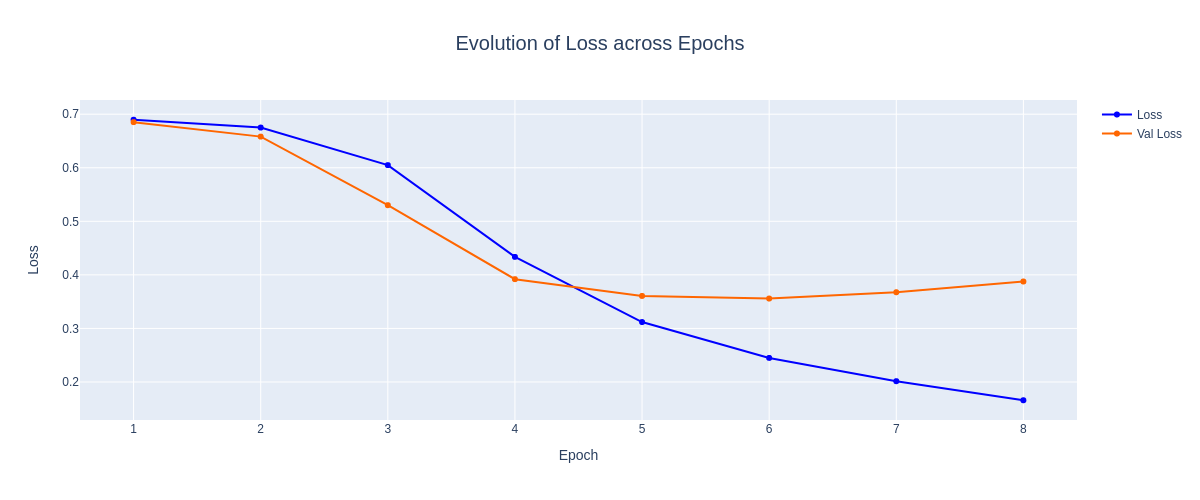

In [ ]:
plot_metrics(renderer="png")

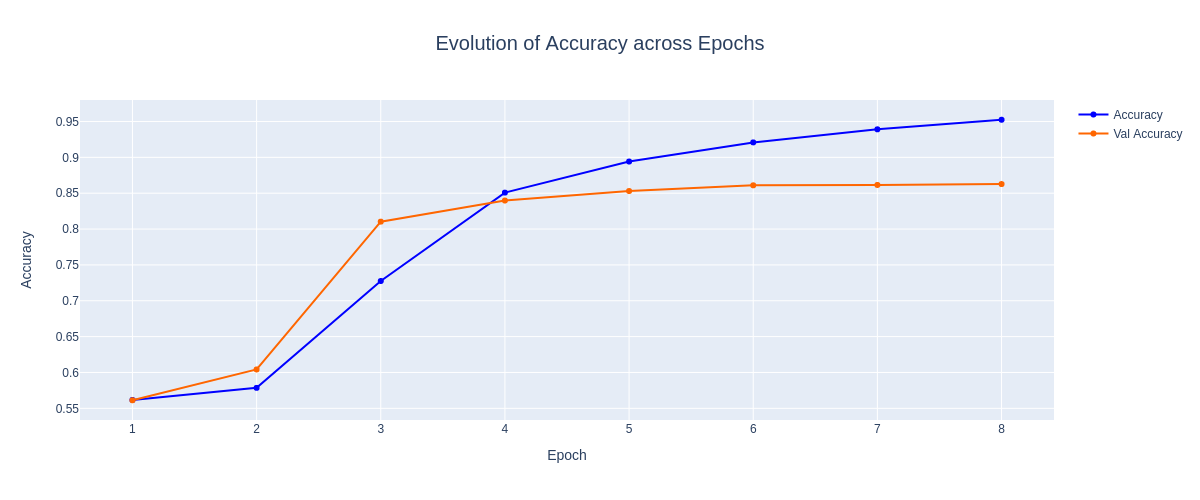

In [ ]:
plot_metrics(renderer="png", metric="accuracy")

**Confusion Matrix**

In [ ]:
labels_test = test_dataset.unbatch().map(lambda text, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [ ]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.8627402046418767

Total non-sarcastic:  2248 ; Total sarcastic:  1759


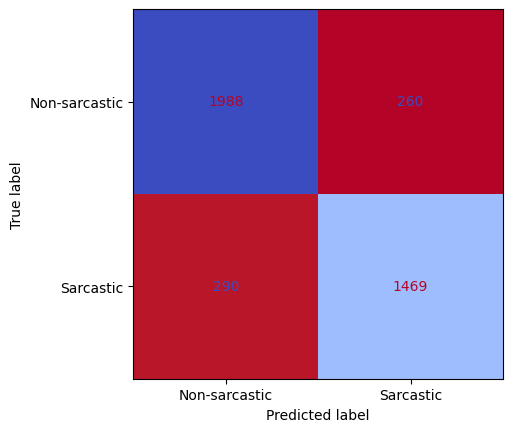

In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Non-sarcastic", "Sarcastic"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total non-sarcastic: ", np.bincount(labels_test)[0], "; Total sarcastic: ", np.bincount(labels_test)[1])

In [ ]:
(260/2248)*100, (290/1759)*100

(11.565836298932384, 16.48664013644116)

It is observed that the model encounters slightly more difficulties in correctly classifying sarcastic news headlines, as reflected in a higher percentage of false negatives (16.5%) compared to false positives (11.6%). Despite employing a bidirectional LSTM network, it is possible that the model lacks sufficient capacity to capture the complex relationships required to detect sarcasm, as humans would, since it is an inherently challenging task. Therefore, it might be pertinent to consider the use of more advanced models, such as Transformer networks, to improve performance in this task.

### **Predictions with the trained model**

In [3]:
# Custom standardization function
@tf.keras.saving.register_keras_serializable()
def preprocessing(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, r"-+", " ")
  text = tf.strings.regex_replace(text, r'[!"#$%&()\*\+,\./:;<=>?@\[\\\]^_`{|}~\']', "")
  return text

In [4]:
# Load model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_Sarcasm.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          1280000   
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [ ]:
def predict_sarcasm(texts, labels, random=True):
  label_names = ["Non-sarcastic Headline", "Sarcastic Headline"]
  label_colors = ["blue", "orange"]
  indice = np.random.choice(len(texts)) if random else 0
  labels_pred = model.predict(texts, verbose=0).squeeze(axis=-1)
  labels_pred = (labels_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>News Headline:</b><br><br>
    {texts[indice].numpy().decode("utf-8")}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[labels_pred[indice]]}">{label_names[labels_pred[indice]]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [ ]:
texts, labels = next(iter(test_dataset))

In [ ]:
predict_sarcasm(texts, labels, random=False)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
predict_sarcasm(texts, labels)

In [ ]:
# More complex news headline
predict_sarcasm(tf.reshape(texts[80], (1,)), tf.reshape(labels[80], (1,)))

Incorrect prediction: the news headline doesn't seem sarcastic, but it is. Classifying it correctly requires a deep understanding of the context, which is challenging even for a human. The LSTM model did not classify it correctly, so it is necessary to resort to Transformer networks, which have attention layers and are pretrained with billions of words.

**Other News Headlines**

In [ ]:
text = "New Study Reveals Surprising Benefits of Meditation for Stress Reduction"
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_sarcasm(text, label)

In [ ]:
text = "Scientists Discover Groundbreaking Method to Turn Water into Wine"
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_sarcasm(text, label)

### **Visualize Word Embeddings with Principal Component Analysis (PCA)**

In [6]:
# Obtaining the vocabulary from the encoder layer and the weights from the trained embedding layer

vocab = model.layers[0].get_vocabulary()
vocab = {word:i for i, word in enumerate(vocab)}

embedding = model.get_layer("embedding").get_weights()[0]
embedding.shape #(vocab_size, embedding_dim)

(20000, 64)

In [7]:
def compute_pca(X, n_components=2):
  pca = PCA(n_components=n_components, random_state=42)
  X_pca = pca.fit_transform(X)
  return X_pca

In [8]:
embedding_2d = compute_pca(embedding)
embedding_3d = compute_pca(embedding, n_components=3)

embedding_2d.shape, embedding_3d.shape

((20000, 2), (20000, 3))

In [9]:
# Some exemplary words
words = ["report", "study", "new", "world", "economy", "breakthrough", "positive", "promising",
         "amazing", "incredible", "ridiculous", "stunning", "astonishing", "shocking", "outrageous", "bizarre"]

colors = ["blue"]*8 + ["orange"]*8

In [10]:
words_2d = np.array([embedding_2d[vocab.get(word, 1)] for word in words]) #Index 1 corresponds to [UNK]
words_3d = np.array([embedding_3d[vocab.get(word, 1)] for word in words])

**With Plotly (interactive graph)**

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=words_2d[:8, 0], y=words_2d[:8, 1],
                         mode="markers+text", marker_color="blue",
                         text=words[:8], textposition="top right",
                         marker_size=10, textfont_size=13,
                         name="not sarcastic"))

fig.add_trace(go.Scatter(x=words_2d[8:, 0], y=words_2d[8:, 1],
                         mode="markers+text", marker_color="orange",
                         text=words[8:], textposition="top right",
                         marker_size=10, textfont_size=13,
                         name="sarcastic"))

fig.update_layout(title="<b>2D Embeddings of News Headline Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  xaxis_title="<b>$Z_1$</b>", yaxis_title="<b>$Z_2$</b>")

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=words_3d[:8, 0], y=words_3d[:8, 1], z=words_3d[:8, 2],
                           mode="markers+text", marker_color="blue",
                           text=words[:8], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="not sarcastic"))

fig.add_trace(go.Scatter3d(x=words_3d[8:, 0], y=words_3d[8:, 1], z=words_3d[8:, 2],
                           mode="markers+text", marker_color="orange",
                           text=words[8:], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="sarcastic"))

fig.update_layout(title="<b>3D Embeddings of News Headline Words</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  scene=dict(xaxis_title="<b>Z_1</b>", yaxis_title="<b>Z_2</b>", zaxis_title="<b>Z_3</b>"))

fig.show()

In [ ]:
# Function to create gifs

def create_gif(gif_file, fig, fps=1):

  images = []
  angles = np.arange(0, 361, 20)

  # Initial Image
  fig.write_image("temp.png")
  images.append(imageio.imread("temp.png"))
  os.remove("temp.png")

  for angle in angles:
    fig.update_layout(scene_camera=dict(
        eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)))
        )
    )
    fig.write_image("temp.png")
    images.append(imageio.imread("temp.png"))
    os.remove("temp.png")

  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    for image in images:
      writer.append_data(image)

In [ ]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 5.4 MB/s eta 0:00:00



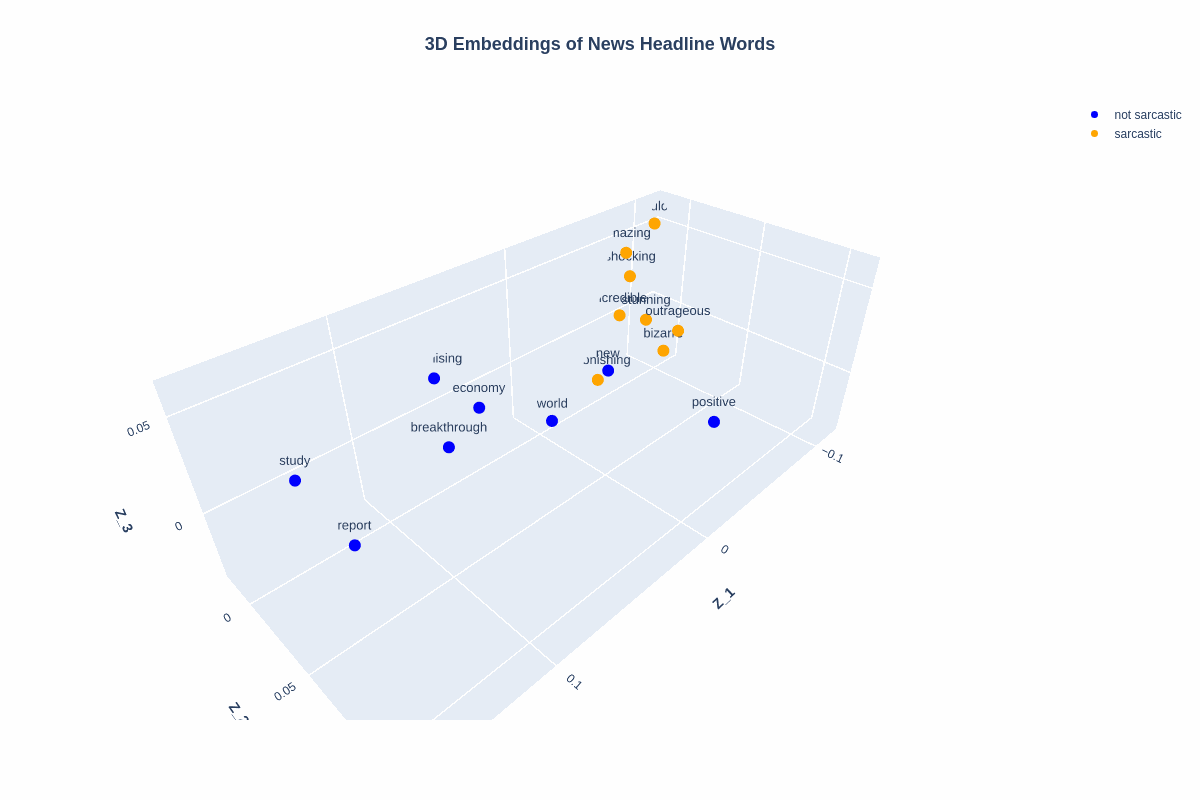

In [ ]:
# Generate a GIF of the 3D word embeddings
directory_images = "/content/drive/MyDrive/images/text_classification"
directory_tc = os.path.join(directory_images, "lstm_sarcasm")
os.makedirs(directory_tc, exist_ok=True)
gif_file = os.path.join(directory_tc, "embedding_3d.gif")

create_gif(gif_file, fig, fps=0.5)
embed.embed_file(gif_file)

**With Matplotlib (for GitHub)**

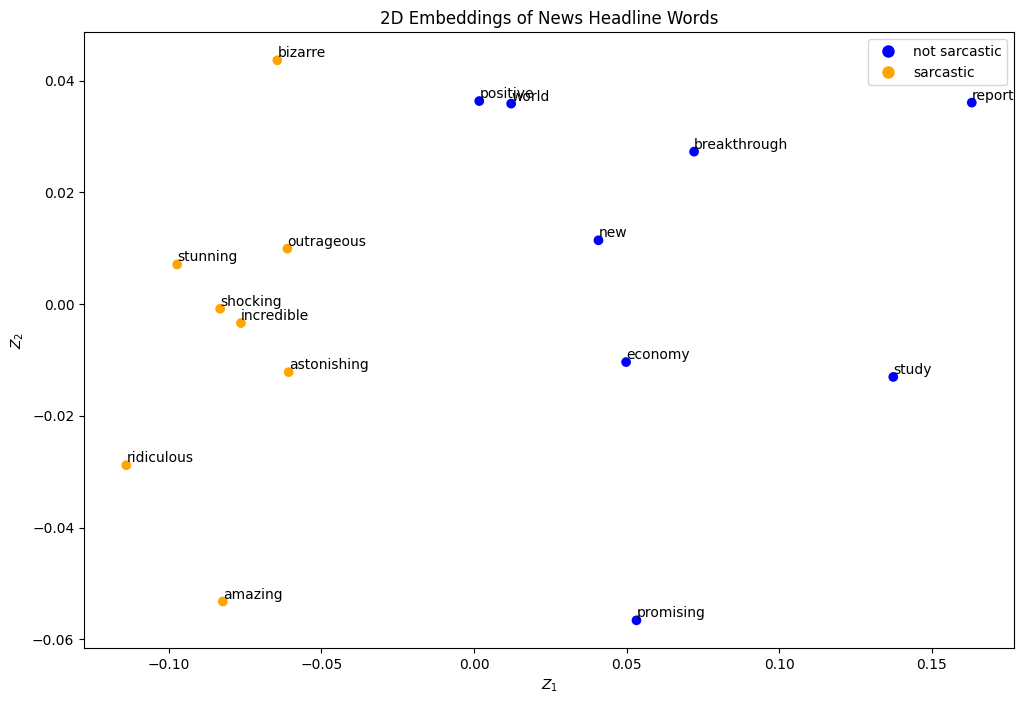

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(words_2d[:, 0], words_2d[:, 1], c=colors)
for i, word in enumerate(words):
    plt.annotate(word, xy=(words_2d[i, 0], words_2d[i, 1]), ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["blue", "orange"], ["not sarcastic", "sarcastic"])]
plt.legend(handles=legend_handles, loc="best")

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.title("2D Embeddings of News Headline Words")
plt.show()

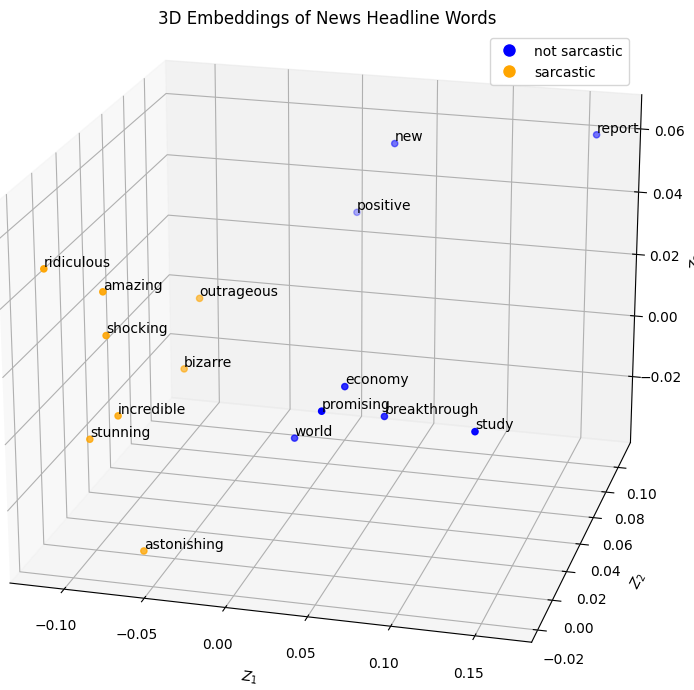

In [12]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(words_3d[:, 0], words_3d[:, 1], words_3d[:, 2], c=colors)

for i, word in enumerate(words):
    ax.text(words_3d[i, 0], words_3d[i, 1], words_3d[i, 2], word, ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["blue", "orange"], ["not sarcastic", "sarcastic"])]
plt.legend(handles=legend_handles, loc="best")

ax.view_init(elev=20, azim=285)
ax.set_box_aspect(None, zoom=1.3)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_zlabel("$Z_3$")
plt.title("3D Embeddings of News Headline Words")
plt.show()

Thanks to the use of **PCA**, we can now visualize the trained weights of the embedding layer in both 2D and 3D. The vector representation of each vocabulary word, previously of dimension 64, has been reduced and projected into a lower-dimensional space. This technique allows us to understand the word distribution more clearly. By observing the arrangement of words in the vector space, we can infer that the model has been successfully trained. Common words in sarcastic news headlines are grouped coherently, as are words associated with non-sarcastic news headlines, suggesting a good capture of semantic relationships. Additionally, there is a clear separation between these two groups of words in the vector space, indicating a good discriminative capacity of the model, despite sarcasm detection being a challenging task.